In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import torch
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
import json
from internal.dataparsers.colmap_dataparser import ColmapDataParser
import internal.utils.colmap as colmap_utils

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
torch.set_grad_enabled(False)
torch.set_printoptions(precision=16)

In [4]:
from internal.utils.partitioning_utils import SceneConfig, PartitionableScene

In [5]:
dataset_path = os.path.expanduser("~/data/image_set/JNUCar_undistorted/colmap/drone/dense_max_2048/0")

# 1. Load dataset

In [6]:
colmap_model = colmap_utils.read_model(os.path.join(dataset_path, "sparse"))
colmap_model = {
    "cameras": colmap_model[0],
    "images": colmap_model[1],
    "points3D": colmap_model[2],
}

len(colmap_model["cameras"]), len(colmap_model["images"]), len(colmap_model["points3D"])

Detected model format: '.bin'


(2, 4857, 2609978)

get camera extrinsics

In [7]:
R_list = []
T_list = []
image_name_list = []
image_idx_to_key = []

for idx, key in enumerate(colmap_model["images"]):
    extrinsics = colmap_model["images"][key]
    image_name_list.append(extrinsics.name)

    R = torch.tensor(extrinsics.qvec2rotmat(), dtype=torch.float)
    T = torch.tensor(extrinsics.tvec, dtype=torch.float)

    R_list.append(R)
    T_list.append(T)
    image_idx_to_key.append(key)

R = torch.stack(R_list)
T = torch.stack(T_list)

assert image_idx_to_key[0] == list(colmap_model["images"].keys())[0]
assert image_idx_to_key[-1] == list(colmap_model["images"].keys())[-1]

R.shape, T.shape, len(image_idx_to_key),

(torch.Size([4857, 3, 3]), torch.Size([4857, 3]), 4857)

In [8]:
# calculate camera-to-world transform matrix
w2c = torch.zeros(size=(R.shape[0], 4, 4), dtype=R.dtype)
w2c[:, :3, :3] = R
w2c[:, :3, 3] = T
w2c[:, 3, 3] = 1.
c2w = torch.linalg.inv(w2c)

get points

In [9]:
max_point_index = max(colmap_model["points3D"].keys())
max_point_index

3232877

In [10]:
point_xyzs = torch.zeros((max_point_index + 1, 3), dtype=torch.float)
point_rgbs = torch.zeros((max_point_index + 1, 3), dtype=torch.uint8)
point_errors = torch.ones((max_point_index + 1), dtype=torch.float).fill_(255.)
point_n_images = torch.zeros((max_point_index + 1), dtype=torch.int)

In [11]:
for idx, point in tqdm(colmap_model["points3D"].items()):
    point_xyzs[idx] = torch.from_numpy(point.xyz)
    point_rgbs[idx] = torch.from_numpy(point.rgb)
    point_errors[idx] = torch.from_numpy(point.error)
    point_n_images[idx] = point.image_ids.shape[0]

  0%|          | 0/2609978 [00:00<?, ?it/s]

reorientation

In [12]:
# calculate the up direction of the scene
# NOTE: 
#   the calculated direction may not be perfect or even incorrect sometimes, 
#   in such a situation, you need to provide a correct up vector
up = -torch.mean(c2w[:, :3, 1], dim=0)
up = up / torch.linalg.norm(up)

rotation = ColmapDataParser.rotation_matrix(up, torch.tensor([0, 0, 1], dtype=up.dtype))
rotation_transform = torch.eye(4, dtype=up.dtype)
rotation_transform[:3, :3] = rotation
up, rotation_transform

(tensor([-0.0037699241656810, -0.9156462550163269, -0.4019673466682434]),
 tensor([[ 0.9999762177467346, -0.0057721207849681,  0.0037699241656810,
           0.0000000000000000],
         [-0.0057721207849681, -0.4019435644149780,  0.9156462550163269,
           0.0000000000000000],
         [-0.0037699241656810, -0.9156462550163269, -0.4019672870635986,
           0.0000000000000000],
         [ 0.0000000000000000,  0.0000000000000000,  0.0000000000000000,
           1.0000000000000000]]))

In [13]:
reoriented_camera_centers = c2w[:, :3, 3] @ rotation_transform[:3, :3].T
reoriented_point_cloud_xyz = point_xyzs @ rotation_transform[:3, :3].T

extract valid points

In [14]:
valid_point_mask = point_n_images > 0
valid_reoriented_point_xyzs = reoriented_point_cloud_xyz[valid_point_mask]
valid_point_rgbs = point_rgbs[valid_point_mask]
len(valid_reoriented_point_xyzs), len(valid_point_rgbs)

(2609978, 2609978)

plot the scene, confirming that it shows in top view

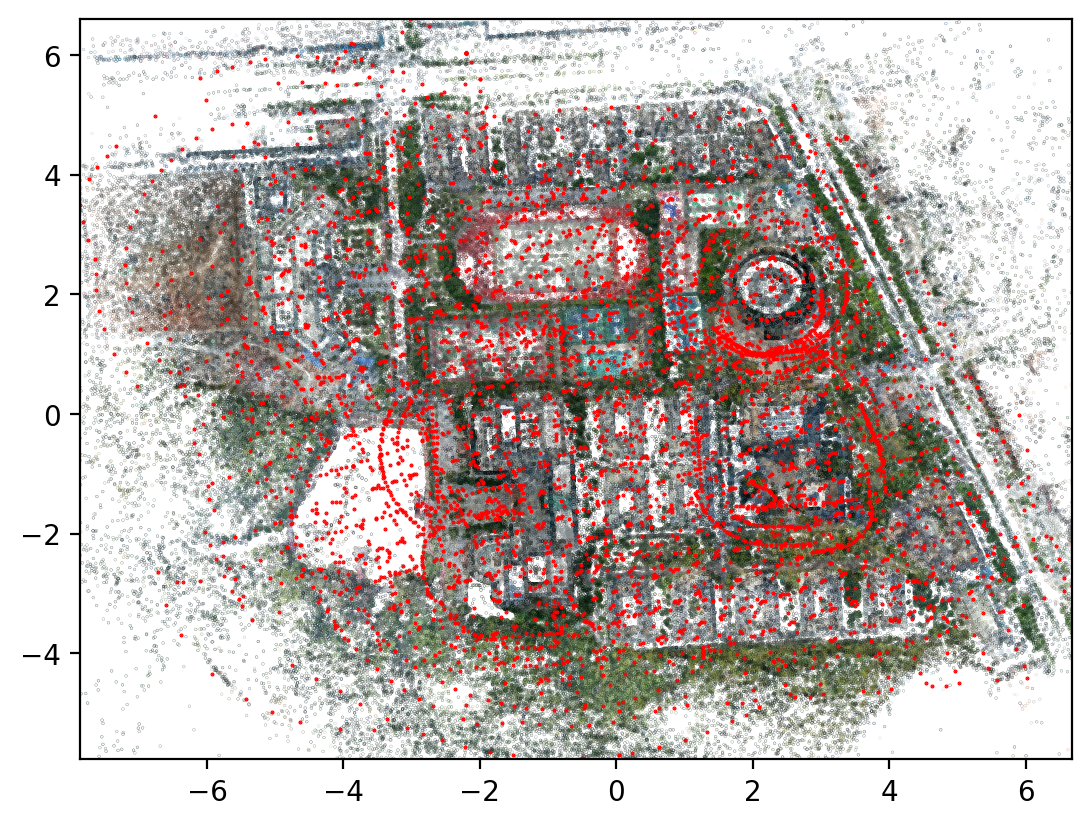

In [15]:
sparsify_points = 4
fig, ax = plt.subplots()
ax.set_aspect('equal', adjustable='box')
scene_size = torch.max(reoriented_camera_centers, dim=0).values - torch.min(reoriented_camera_centers, dim=0).values
ax.set_xlim([torch.min(reoriented_camera_centers[:, 0]) - 0.1 * scene_size[0], torch.max(reoriented_camera_centers[:, 0]) + 0.1 * scene_size[0]])
ax.set_ylim([torch.min(reoriented_camera_centers[:, 1]) - 0.1 * scene_size[1], torch.max(reoriented_camera_centers[:, 1]) + 0.1 * scene_size[1]])
ax.scatter(valid_reoriented_point_xyzs[::sparsify_points, 0], valid_reoriented_point_xyzs[::sparsify_points, 1], c=valid_point_rgbs[::sparsify_points] / 255., s=0.01)
ax.scatter(reoriented_camera_centers[:, 0], reoriented_camera_centers[:, 1], s=0.2, c="red")
plt.show()

# 2. Build partitions

choose scene origin and partition size

In [16]:
scene_config = SceneConfig(
    origin=torch.tensor([0., 0.]),
    partition_size=3.,
)
scene = PartitionableScene(scene_config, reoriented_camera_centers[..., :2])

calculate bounding box and number of partitions

In [17]:
scene.get_bounding_box_by_camera_centers()

MinMaxBoundingBox(min=tensor([-7.8559217453002930, -5.7590188980102539]), max=tensor([6.6817197799682617, 6.5958681106567383]))

In [18]:
scene.get_scene_bounding_box()

SceneBoundingBox(bounding_box=MinMaxBoundingBox(min=tensor([-9., -6.]), max=tensor([9., 9.])), n_partitions=tensor([6, 5]), origin_partition_offset=tensor([-3, -2]))

plot bounding box

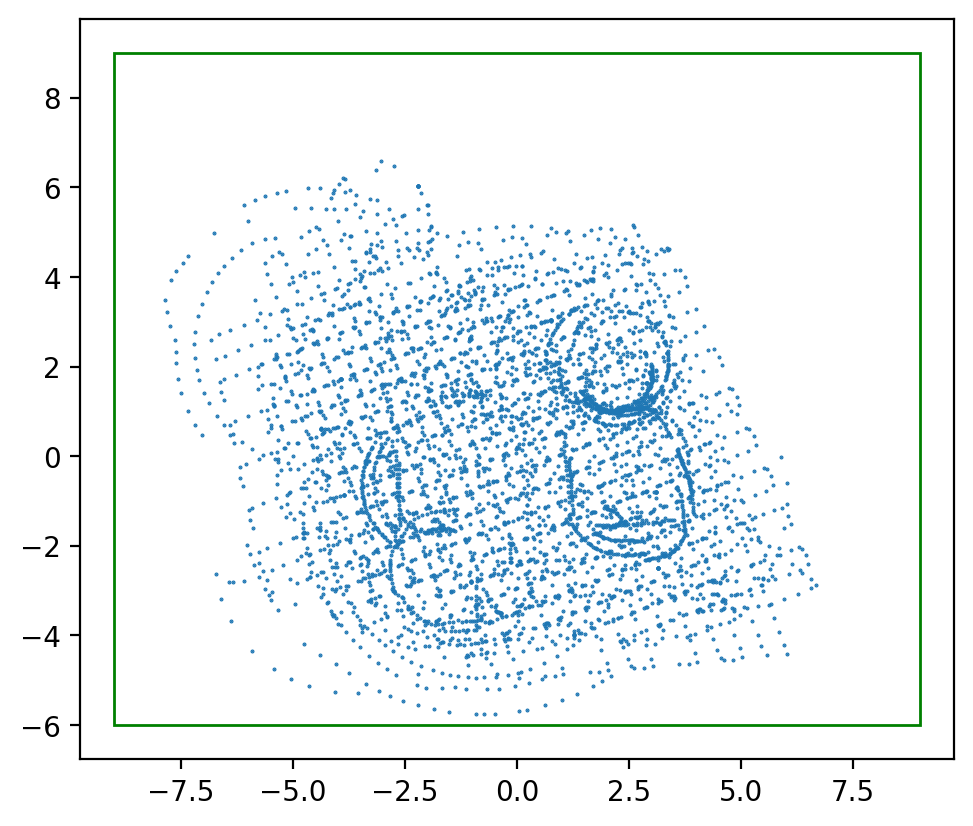

In [19]:
scene.plot(scene.plot_scene_bounding_box)

build partition coordinates

In [20]:
scene.build_partition_coordinates()

PartitionCoordinates(id=tensor([[-3, -2],
        [-2, -2],
        [-1, -2],
        [ 0, -2],
        [ 1, -2],
        [ 2, -2],
        [-3, -1],
        [-2, -1],
        [-1, -1],
        [ 0, -1],
        [ 1, -1],
        [ 2, -1],
        [-3,  0],
        [-2,  0],
        [-1,  0],
        [ 0,  0],
        [ 1,  0],
        [ 2,  0],
        [-3,  1],
        [-2,  1],
        [-1,  1],
        [ 0,  1],
        [ 1,  1],
        [ 2,  1],
        [-3,  2],
        [-2,  2],
        [-1,  2],
        [ 0,  2],
        [ 1,  2],
        [ 2,  2]], dtype=torch.int32), xy=tensor([[-9., -6.],
        [-6., -6.],
        [-3., -6.],
        [ 0., -6.],
        [ 3., -6.],
        [ 6., -6.],
        [-9., -3.],
        [-6., -3.],
        [-3., -3.],
        [ 0., -3.],
        [ 3., -3.],
        [ 6., -3.],
        [-9.,  0.],
        [-6.,  0.],
        [-3.,  0.],
        [ 0.,  0.],
        [ 3.,  0.],
        [ 6.,  0.],
        [-9.,  3.],
        [-6.,  3.],
        [-3.

plot partitions

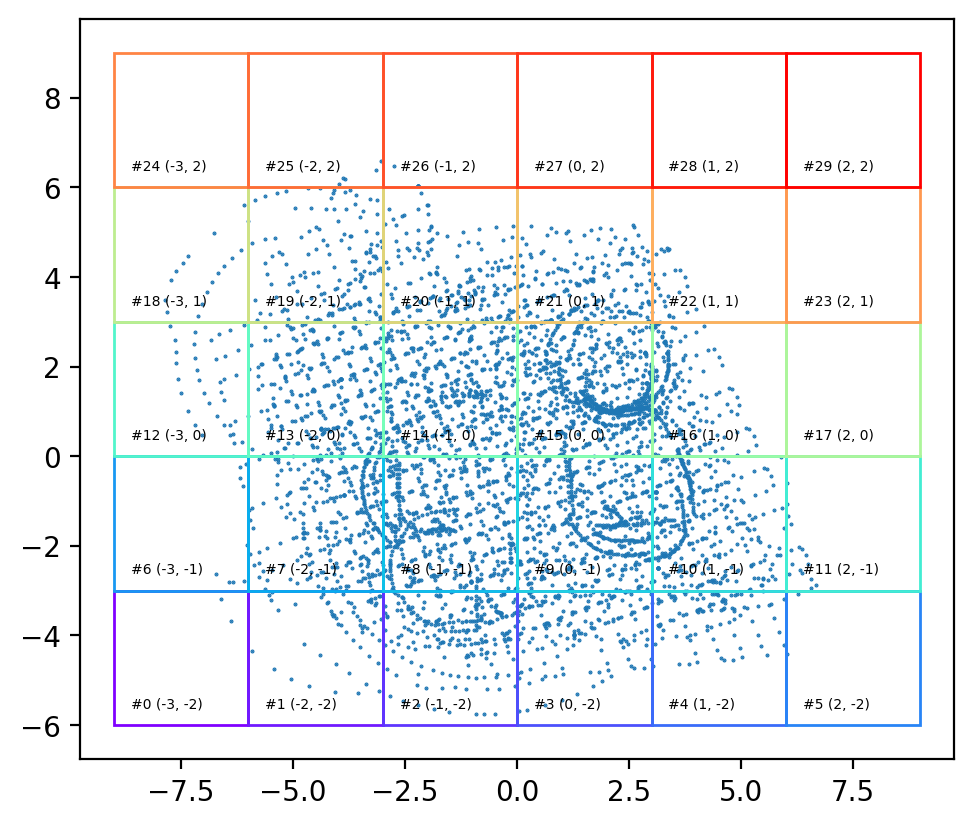

In [21]:
scene.plot(scene.plot_partitions)

# 3. Assign images to partitions

## 3.1. Location based assignment

In [22]:
scene_config.location_based_enlarge = 0.1

In [23]:
scene.camera_center_based_partition_assignment().sum(-1)

tensor([   7,  106,  347,  265,  154,   10,   22,  463,  748,  790,  513,   27,
          53,  449,  708, 1019,  412,    1,   27,  196,  291,  302,   64,    0,
           1,   20,   13,    0,    0,    0])

## 3.2. Visibility based assignment

the visibility is calculated from 3D points of every camera

In [24]:
# some parameters may need to be changed
scene_config.visibility_based_distance = 0.9  # enlarge bounding box by `partition_size * max_visible_distance`, only those cameras inside this enlarged box will be used for visibility based assignment
scene_config.visibility_threshold = 0.1

define image 3D point getter

In [25]:
# filter out points with large errors
min_cameras = 3
max_errors = 2.

shared_point_mask = torch.logical_and(
    torch.ge(point_n_images, min_cameras),
    torch.le(point_errors, max_errors),
)

shared_point_mask.sum()

tensor(2338223)

In [26]:
def get_image_points(image_idx: int):
    image_key = image_idx_to_key[image_idx]
    # get valid points
    points_ids = torch.from_numpy(colmap_model["images"][image_key].point3D_ids)
    points_ids = points_ids[points_ids > 0]
    
    # filter
    points_ids *= shared_point_mask[points_ids]
    points_ids = points_ids[points_ids > 0]
    
    return reoriented_point_cloud_xyz[points_ids]

start calculating visibilities

In [27]:
scene.calculate_point_based_camera_visibilities(
    point_getter=get_image_points,
    device=reoriented_point_cloud_xyz.device,
).shape

  0%|          | 0/4857 [00:00<?, ?it/s]

torch.Size([30, 4857])

assign cameras to partitions based on visibilities

In [28]:
scene.visibility_based_partition_assignment().sum(dim=-1)

tensor([  0,  68, 215, 182, 114,  14,  12,  93, 695, 583, 308,  39,  87, 297,
        450, 518, 225,   0,  25, 179, 253, 183,  71,   0,   0,  24,  12,   0,
          0,   0])

# 4. Preview

In [29]:
max_plot_points = 51_200
plot_point_sparsify = max(valid_reoriented_point_xyzs.shape[0] // max_plot_points, 1)
plot_point_sparsify

50

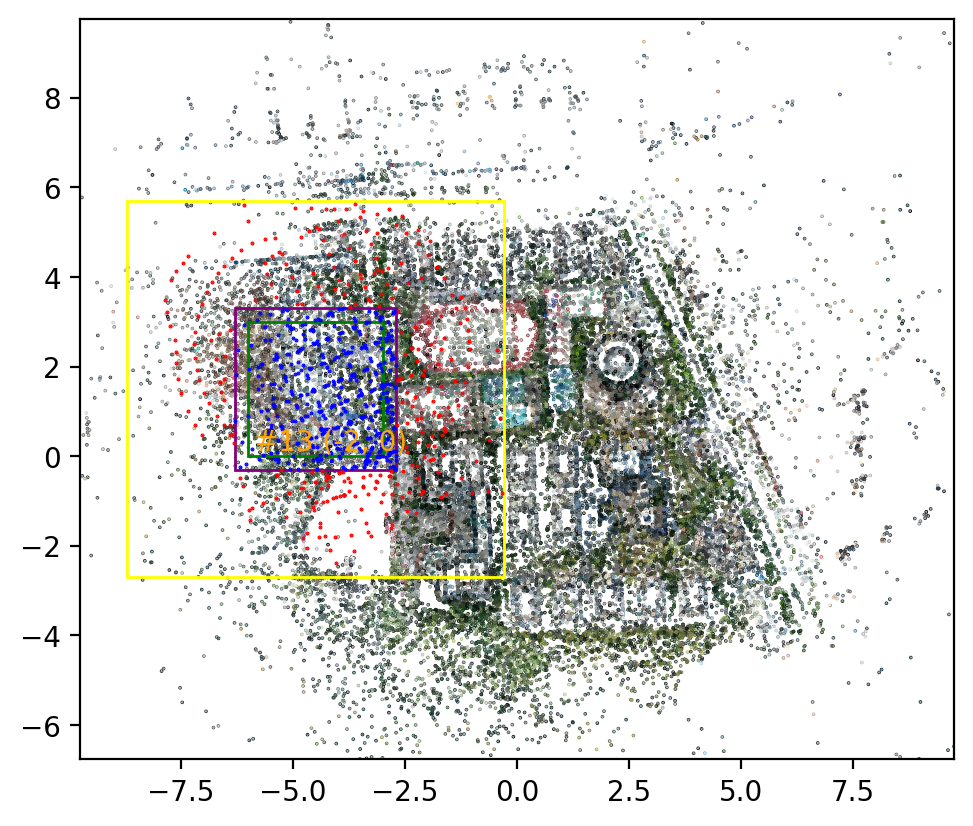

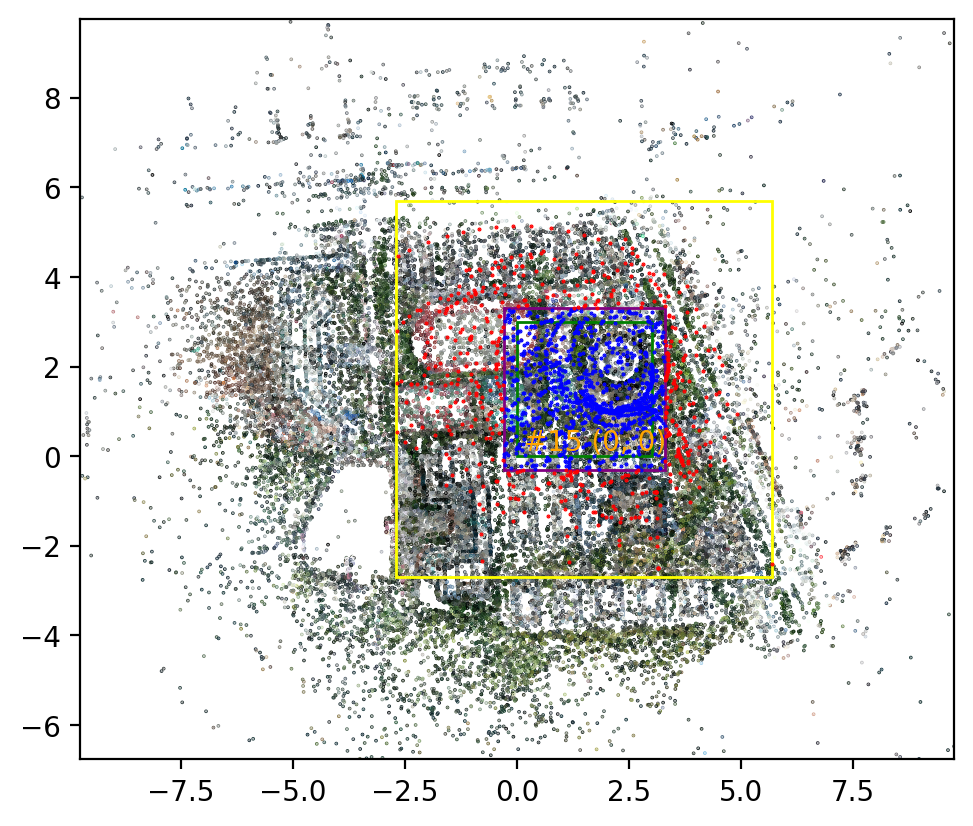

In [30]:
# for idx in range(len(scene.partition_coordinates)):
    # scene.plot(scene.plot_partition_assigned_cameras, idx, valid_reoriented_point_xyzs, valid_point_rgbs, point_sparsify=plot_point_sparsify)
scene.plot(scene.plot_partition_assigned_cameras, 13, valid_reoriented_point_xyzs, valid_point_rgbs, point_sparsify=plot_point_sparsify)
scene.plot(scene.plot_partition_assigned_cameras, 15, valid_reoriented_point_xyzs, valid_point_rgbs, point_sparsify=plot_point_sparsify)

# 5. Saving

In [31]:
output_path = os.path.join(dataset_path, scene.build_output_dirname())
output_path

'/home/zhensheng/data/image_set/JNUCar_undistorted/colmap/drone/dense_max_2048/0/partitions-size_3.0-enlarge_0.1-visibility_0.9_0.1'

In [32]:
torch.load(scene.save(
    output_path,
    extra_data={
        "up": up,
        "rotation_transform": rotation_transform,
    }
))

{'scene_config': {'origin': tensor([0., 0.]),
  'partition_size': 3.0,
  'location_based_enlarge': 0.1,
  'visibility_based_distance': 0.9,
  'visibility_threshold': 0.1},
 'scene_bounding_box': {'bounding_box': {'min': tensor([-9., -6.]),
   'max': tensor([9., 9.])},
  'n_partitions': tensor([6, 5]),
  'origin_partition_offset': tensor([-3, -2])},
 'partition_coordinates': {'id': tensor([[-3, -2],
          [-2, -2],
          [-1, -2],
          [ 0, -2],
          [ 1, -2],
          [ 2, -2],
          [-3, -1],
          [-2, -1],
          [-1, -1],
          [ 0, -1],
          [ 1, -1],
          [ 2, -1],
          [-3,  0],
          [-2,  0],
          [-1,  0],
          [ 0,  0],
          [ 1,  0],
          [ 2,  0],
          [-3,  1],
          [-2,  1],
          [-1,  1],
          [ 0,  1],
          [ 1,  1],
          [ 2,  1],
          [-3,  2],
          [-2,  2],
          [-1,  2],
          [ 0,  2],
          [ 1,  2],
          [ 2,  2]], dtype=torch.int32

In [33]:
is_images_assigned_to_partitions = torch.logical_or(scene.is_camera_in_partition, scene.is_partitions_visible_to_cameras)
is_images_assigned_to_partitions.sum(-1)

tensor([   7,  174,  562,  447,  268,   24,   34,  556, 1443, 1373,  821,   66,
         140,  746, 1158, 1537,  637,    1,   52,  375,  544,  485,  135,    0,
           1,   44,   25,    0,    0,    0])

write image lists

In [34]:
written_idx_list = []
for partition_idx in tqdm(list(range(is_images_assigned_to_partitions.shape[0]))):
    partition_image_indices = is_images_assigned_to_partitions[partition_idx].nonzero().squeeze(-1).tolist()
    if len(partition_image_indices) == 0:
        continue
        
    written_idx_list.append(partition_idx)
        
    camera_list = []
    
    with open(os.path.join(output_path, "{}.txt".format(scene.partition_coordinates.get_str_id(partition_idx))), "w") as f:
        for image_index in partition_image_indices:
            f.write(image_name_list[image_index])
            f.write("\n")
            
            # below camera list is just for visualization, not for training, so its camera intrinsics are fixed values
            color = [0, 0, 255]
            if scene.is_partitions_visible_to_cameras[partition_idx][image_index]:
                color = [255, 0, 0]
            camera_list.append({
                "id": image_index,
                "img_name": image_name_list[image_index],
                "width": 1920,
                "height": 1080,
                "position": c2w[image_index][:3, 3].numpy().tolist(),
                "rotation": c2w[image_index][:3, :3].numpy().tolist(),
                "fx": 1600,
                "fy": 1600,
                "color": color,
            })
            
    with open(os.path.join(
            output_path, 
            f"cameras-{scene.partition_coordinates.get_str_id(partition_idx)}.json",
    ), "w") as f:
        json.dump(camera_list, f, indent=4, ensure_ascii=False)

  0%|          | 0/30 [00:00<?, ?it/s]

In [35]:
max_store_points = 512_000
store_point_step = max(valid_point_rgbs.shape[0] // max_store_points, 1)
from internal.utils.graphics_utils import store_ply
store_ply(os.path.join(output_path, "points.ply"), point_xyzs[valid_point_mask][::store_point_step], valid_point_rgbs[::store_point_step])

In [36]:
print("Run below commands to visualize the partitions in web viewer:\n")
for partition_idx in written_idx_list:
    id_str = scene.partition_coordinates.get_str_id(partition_idx)
    print("python utils/show_cameras.py \\\n    --cameras='{}' \\\n    --points='{}'\n".format(
        os.path.join(output_path, "cameras-{}.json".format(id_str)),
        os.path.join(output_path, "points.ply"),
    ))

Run below commands to visualize the partitions in web viewer:

python utils/show_cameras.py \
    --cameras='/home/zhensheng/data/image_set/JNUCar_undistorted/colmap/drone/dense_max_2048/0/partitions-size_3.0-enlarge_0.1-visibility_0.9_0.1/cameras--03_-02.json' \
    --points='/home/zhensheng/data/image_set/JNUCar_undistorted/colmap/drone/dense_max_2048/0/partitions-size_3.0-enlarge_0.1-visibility_0.9_0.1/points.ply'

python utils/show_cameras.py \
    --cameras='/home/zhensheng/data/image_set/JNUCar_undistorted/colmap/drone/dense_max_2048/0/partitions-size_3.0-enlarge_0.1-visibility_0.9_0.1/cameras--02_-02.json' \
    --points='/home/zhensheng/data/image_set/JNUCar_undistorted/colmap/drone/dense_max_2048/0/partitions-size_3.0-enlarge_0.1-visibility_0.9_0.1/points.ply'

python utils/show_cameras.py \
    --cameras='/home/zhensheng/data/image_set/JNUCar_undistorted/colmap/drone/dense_max_2048/0/partitions-size_3.0-enlarge_0.1-visibility_0.9_0.1/cameras--01_-02.json' \
    --points='/hom